# Collaborative Filtering Recommendations - Item-Based kNN based on FastRP embeddings

## Introduction

Use Fast Random Projection to create embeddings for Poi and User nodes, then use K-Nearest Neighbors to compute the similarity between User Nodes.

When making recommendation, find the most similar users and recommend other pois that they are alse interested.

[the K-Nearest Neighbors algorithm (kNN)](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/): identify similar nodes and base recommendations on that. 

[FastRP](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/). leverage topological information about the graph in kNN, first create node embeddings to be the input to the kNN algorithm.

## Prerequisites

Neo4j server with a recent version (2.0+) of GDS installed.

The `graphdatascience` Python library to operate Neo4j GDS.

`Cypher` query to generate recommendations

## Setup

Installing and importing  dependencies, and setting up GDS client connection to the database.

In [44]:
# Install necessary dependencies
%pip install graphdatascience
%pip install matplotlib
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.model_selection (from versions: none)
ERROR: No matching distribution found for sklearn.model_selection

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import configparser

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from graphdatascience import GraphDataScience


c:\Users\xiong\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
DATABASE = 'neo4j'
PASSWORD = 'password'

NEO4J_CONF_FILE = 'neo4j.ini'

if NEO4J_CONF_FILE is not None and os.path.exists(NEO4J_CONF_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_CONF_FILE)
    HOST = config['NEO4J']['HOST']
    DATABASE = config['NEO4J']['DATABASE']
    PASSWORD = config['NEO4J']['PASSWORD']
    print(f'Using custom database properties \nHOST: {HOST}; DATABASE: {DATABASE}; PASSWORD: {PASSWORD}')
else:
    print('Could not find database properties file, using defaults')

# Connecting with the Neo4j database using GDS library
gds = GraphDataScience(HOST,auth=(DATABASE, PASSWORD))

Using custom database properties 
HOST: bolt://44.199.250.187:7687; DATABASE: neo4j; PASSWORD: braids-agent-overvoltage


## Projecting into GDS

Project graph into memory where GDS can operate on and analyze data

In [5]:
# When re-running, remove the previously created graph if needed
#gds.graph.drop('myGraph')

graphName                                                          myGraph
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            58725
relationshipCount                                                   170068
configuration            {'relationshipProjection': {'REVIEWED': {'aggr...
density                                                           0.000049
creationTime                           2024-03-09T06:42:49.115688170+00:00
modificationTime                       2024-03-09T06:57:49.962132173+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'em...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'em...
Name: 0, dtype: object

In [3]:
# define how to project database into GDS
node_projection = ["User", "Poi"]
relationship_projection = {"REVIEWED": {"orientation": "UNDIRECTED", "properties": "rating"}}

# Before actual projection, estimate how much memory is required
result = gds.graph.project.estimate(node_projection, relationship_projection)

print(f"Required memory for native loading: {result['requiredMemory']}")

Required memory for native loading: [10930 KiB ... 12130 KiB]


In [4]:
# proceed with projection
G, result = gds.graph.project("myGraph", node_projection, relationship_projection)

print(f"The projection took {result['projectMillis']} ms")

# methods on `G` to check if the projection looks correct
print(f"Graph '{G.name()}' node count: {G.node_count()}")
print(f"Graph '{G.name()}' node labels: {G.node_labels()}")

The projection took 190 ms
Graph 'myGraph' node count: 58725
Graph 'myGraph' node labels: ['User', 'Poi']


## Creating FastRP node embeddings

In order to do collaborative filtering, generate node embeddings that capture topological information from the graph, as input for KNN later.

`embeddingDimension` set to 256 for a graph which has more than 50k nodes. 

Run FastRP’s mutate mode to write the embedding property to the projected graph.

[the syntax section of the FastRP documentation](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/#algorithms-fastrp-syntax) 

In [5]:
# We can also estimate memory of running algorithms like FastRP, so let's do that first
result = gds.fastRP.mutate.estimate(
    G,
    randomSeed=42,
    embeddingDimension=256,
    relationshipWeightProperty="rating",
    iterationWeights=[0, 1, 1, 1],
    mutateProperty="embedding"
)

print(f"Required memory for running FastRP: {result['requiredMemory']}")

Required memory for running FastRP: 177 MiB


In [6]:
# Now let's run FastRP and mutate our projected graph with the results
result = gds.fastRP.mutate(
    G,
    randomSeed=42,
    embeddingDimension=256,
    relationshipWeightProperty="rating",
    iterationWeights=[0, 1, 1, 1],
    mutateProperty="embedding"
)

# Let's make sure we got an embedding for each node
print(f"Number of embedding vectors produced: {result['nodePropertiesWritten']}")

Number of embedding vectors produced: 58725


## Similarities with kNN

identify similar nodes by using the node embeddings generated with FastRP as `nodeProperties`. 

Use the algorithm’s write mode to write the properties and relationships back to database, analyze them later using Cypher.

[the syntax section of the kNN documentation](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/#algorithms-knn-syntax) 

In [12]:
def topK_tuning():
    
    top_k_list = []

    for k in range(1,30):
        result = gds.knn.write(
        G,
        topK=k,
        nodeLabels=['Poi'],
        nodeProperties=["embedding"],
        randomSeed=42,
        concurrency=1,
        sampleRate=1.0,
        deltaThreshold=0.0,
        similarityCutoff = 0.5,
        writeRelationshipType="CF_SIMILAR_POI_"+str(k),
        writeProperty="score",

        )
        print(f"topK = {k}")
        print(f"Relationships produced: {result['relationshipsWritten']}")
        print(f"Nodes compared: {result['nodesCompared']}")
        print(f"Mean similarity: {result['similarityDistribution']['mean']}")

        top_k_list.append([k, result['similarityDistribution']['mean']])
    
    return top_k_list

In [13]:
top_k_list = topK_tuning() 

# duration of this function will take more than 30 minutes,
# to save re-running time, save the result of top_k_list here

#top_k_list = [[1, 0.5615123804064764], [2, 0.5623639701069265], [3, 0.5574946380467807], [4, 0.554076719975126], [5, 0.5512441994487376], [6, 0.5485879465001793], [7, 0.546071125607066], [8, 0.5438574500705885], [9, 0.5419597656446571], [10, 0.5401918273041214], [11, 0.5385650363364238], [12, 0.5370458427834626], [13, 0.5355762111702093], [14, 0.5341640101209684], [15, 0.5327862467742772], [16, 0.5314491520757261], [17, 0.5301647722873541], [18, 0.5289336863347298], [19, 0.5277449144469609], [20, 0.5265708840411643], [21, 0.5254155824396675], [22, 0.524274883848248], [23, 0.5231545141228505], [24, 0.522049569853262], [25, 0.5209552411065586], [26, 0.5198528657655918], [27, 0.5187570773588991], [28, 0.5176656172142265], [29, 0.5165905988198528]]

print(top_k_list)

topK = 1
Relationships produced: 69
Nodes compared: 69
Mean similarity: 0.5615123804064764
topK = 2
Relationships produced: 138
Nodes compared: 69
Mean similarity: 0.5623639701069265
topK = 3
Relationships produced: 207
Nodes compared: 69
Mean similarity: 0.5574946380467807
topK = 4
Relationships produced: 276
Nodes compared: 69
Mean similarity: 0.554076719975126
topK = 5
Relationships produced: 345
Nodes compared: 69
Mean similarity: 0.5512441994487376
topK = 6
Relationships produced: 414
Nodes compared: 69
Mean similarity: 0.5485879465001793
topK = 7
Relationships produced: 483
Nodes compared: 69
Mean similarity: 0.546071125607066
topK = 8
Relationships produced: 552
Nodes compared: 69
Mean similarity: 0.5438574500705885
topK = 9
Relationships produced: 621
Nodes compared: 69
Mean similarity: 0.5419597656446571
topK = 10
Relationships produced: 690
Nodes compared: 69
Mean similarity: 0.5401918273041214
topK = 11
Relationships produced: 759
Nodes compared: 69
Mean similarity: 0.538565

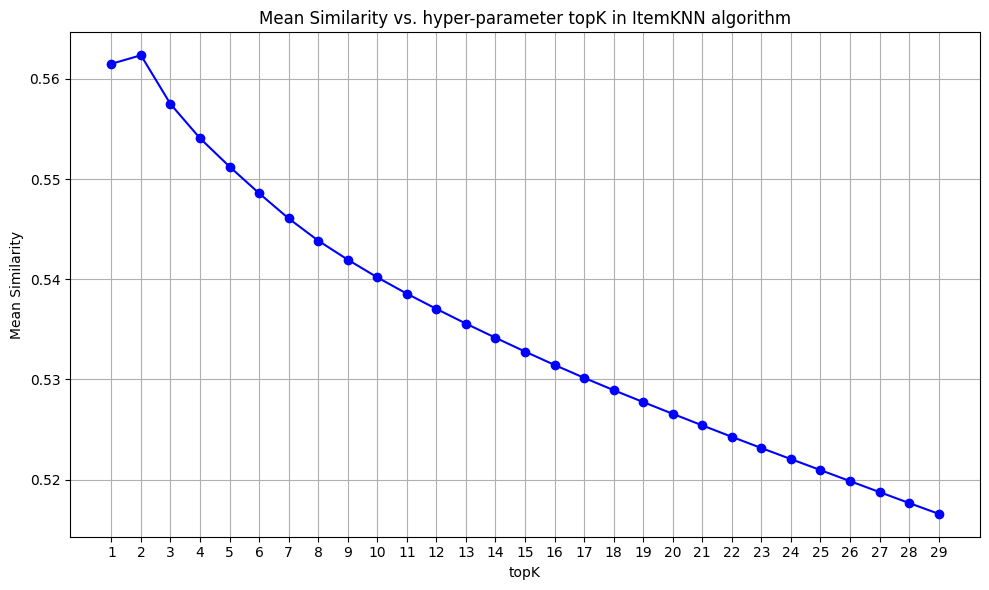

In [61]:
# visualize the Mean Similarity vs. topK trend

# Convert the list to a DataFrame
df_topK = pd.DataFrame(top_k_list, columns=['topK', 'mean_similarity'])

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_topK['topK'], df_topK['mean_similarity'], marker='o', color='b', linestyle='-')
plt.title('Mean Similarity vs. hyper-parameter topK in ItemKNN algorithm')
plt.xlabel('topK')
plt.ylabel('Mean Similarity')
plt.grid(True)
plt.xticks(df_topK['topK'])
plt.tight_layout()
plt.show()

In [15]:
# get the best topK

# Find the index of the row with the maximum mean_similarity
max_index = df_topK['mean_similarity'].idxmax()

# Retrieve the topK value corresponding to the maximum mean_similarity
topK_best = df_topK.loc[max_index, 'topK']

print("TopK value corresponding to the maximum mean_similarity:", topK_best)


TopK value corresponding to the maximum mean_similarity: 2


In [7]:
# Similarity with Item-based KNN

# Run the kNN with optimal topK hyperparameter and write back to db

topK_best = 2

result = gds.knn.write(
    G,
    topK=topK_best,
    nodeLabels = ['Poi'],
    nodeProperties=["embedding"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    similarityCutoff = 0.5,
    writeRelationshipType="CF_SIMILAR_POI",
    writeProperty="score"
)

print(f"Relationships produced: {result['relationshipsWritten']}")
print(f"Nodes compared: {result['nodesCompared']}")
print(f"Mean similarity: {result['similarityDistribution']['mean']}")

Relationships produced: 112
Nodes compared: 69
Mean similarity: 0.6929127488817487


## Exploring the results

Inspect the results of our kNN call by using Cypher. 

Use the `SIMILARITY` relationship type to filter out the relationships.

In [8]:
# find the pair-wise maximum similarity
gds.run_cypher(
    """
        MATCH (p1:Poi)-[r:CF_SIMILAR_POI]->(p2:Poi)
        RETURN p1.name AS poi1, p2.name AS poi2, r.score AS similarity
        ORDER BY similarity DESCENDING, poi1, poi2
        LIMIT 30
    """
)

,poi1,poi2,similarity
0,Singapore Mass Rapid Transit (SMRT),Telok Ayer Street,0.870184
1,Telok Ayer Street,Singapore Mass Rapid Transit (SMRT),0.870184
2,City Hall Building,Singapore Mass Rapid Transit (SMRT),0.808063
3,Singapore Mass Rapid Transit (SMRT),City Hall Building,0.808063
4,313@somerset,Singapore Mass Rapid Transit (SMRT),0.787605
5,City Hall Building,City Square Mall,0.784053
6,City Square Mall,City Hall Building,0.784053
7,Hill Street Building,Singapore Mass Rapid Transit (SMRT),0.778395
8,Hill Street Building,Supertree Grove,0.778276
9,Supertree Grove,Hill Street Building,0.778276


In [9]:
# find the minimum similarity between users
gds.run_cypher(
    """
        MATCH (p1:Poi)-[r:CF_SIMILAR_POI]->(p2:Poi)
        RETURN p1.name AS poi1, p2.name AS poi2, r.score AS similarity
        ORDER BY similarity ASC, poi1, poi2
        LIMIT 30
    """
)

,poi1,poi2,similarity
0,CÉ LA VI Singapore,Maxwell Food Centre,0.523004
1,Let's Go Cook Singapore,Commune Kitchen,0.523361
2,Changi Experience Studio,Singapore Zoo,0.529990
3,Let's Go Cook Singapore,Tea Chapter,0.546988
4,Changi Experience Studio,Surviving the Japanese Occupation: War and Its...,0.548533
5,Virtual Room: Virtual Reality Singapore,Sri Krishnan Temple,0.556511
6,Commune Kitchen,Telok Ayer Street,0.558237
7,Virtual Room: Virtual Reality Singapore,Kusu Island,0.560636
8,Commune Kitchen,Singapore Mass Rapid Transit (SMRT),0.563938
9,Flyer Lounge @ Singapore Flyer,Singapore Flyer,0.565370


kNN results indicate the similarity among users range from 0.523004 to 0.870184.

## Making recommendations

Make poi recommendations for user from other similar users using a simple Cypher query.

In [9]:
# FUNCTION: make recommendation based on Collaborative Filtering Recommendations - Item-Based kNN based on FastRP embeddings
# INPUT: poi_id
# OUTPUT: dataframe[poi_id, rec_poi_id]

def itemKNN_recommendation(poi_id):
    result = gds.run_cypher(
        """
            MATCH (p1:Poi {id: $target_poi})-[s:CF_SIMILAR_POI]->(p2:Poi)
            RETURN p1.id as poi_id, p2.id as rec_poi_id
            ORDER BY s.score DESC, p2.avgRating DESC
        """, params = {'target_poi': poi_id}
    )
    result = result.drop_duplicates()
    return result

In [12]:
# target poi id
poi_id = 2139492

itemKNN_recommendation(poi_id)

,poi_id,rec_poi_id
0,2139492,317421
1,2139492,8016698


# Evaluation

In [3]:
# dataframes of pois
df_pois = gds.run_cypher("""\
    MATCH (poi:Poi)    
    RETURN poi.id
    """)

df_pois

,poi.id
0,2149128
1,310900
2,4400781
3,324542
4,678639
...,...
64,17821111
65,17738872
66,26356283
67,21353012


In [4]:
# dataframes of reviews
# duration: 37s

df_reviews = gds.run_cypher("""\
    MATCH (user:User)-[review:REVIEWED]->(poi:Poi)
    RETURN user.id AS user_id, poi.id AS poi_id
    """)

df_reviews

,user_id,poi_id
0,847,2149128
1,21070,2149128
2,21061,2149128
3,21003,2149128
4,21227,2149128
...,...,...
85029,58650,7275891
85030,58652,7275891
85031,58654,17821111
85032,58656,17821111


In [5]:
# Group by 'user_id' and count occurrences
user_counts = df_reviews.groupby('user_id').size()

# Filter out users with less than 5 occurrences
valid_users = user_counts[user_counts >= 5].index

# Filter the original DataFrame based on valid users
filtered_df_reviews = df_reviews[df_reviews['user_id'].isin(valid_users)].copy()
filtered_df_reviews

,user_id,poi_id
277,20980,2149128
329,20419,2149128
644,20445,2149128
712,20803,2149128
764,20108,2149128
...,...,...
84680,1753,1888873
84685,39201,1888873
84688,6967,1888873
84702,21691,1888873


In [6]:
# Splitting the dataset into 90% training and 10% test sets
df_train, df_test = train_test_split(filtered_df_reviews, test_size=0.1, random_state=100)

df_train

,user_id,poi_id
43559,14882,678639
52599,17393,8634325
78604,25812,315470
81971,8079,13078277
66625,13223,8016698
...,...,...
80529,29227,310896
47967,29380,1837767
14022,7053,2149128
4555,16889,2149128


In [7]:
df_test

,user_id,poi_id
14227,7435,2149128
48823,23137,1837767
59373,41985,1888876
12031,9481,2149128
81597,11220,2138910
...,...,...
44908,4635,678639
82916,38946,2139492
57328,27424,644919
53084,41524,317415


In [10]:
# retrieve recommendation for row in test set
# duration: 500 instances takes 2 minutes

df_all_retrieved = pd.DataFrame()
for index, row in df_test.iterrows():
    poi_id = row['poi_id']

    recommended_interactions = itemKNN_recommendation(poi_id)

    # Concatenate recommended_interactions with test_recommendations
    df_all_retrieved = pd.concat([df_all_retrieved, recommended_interactions], ignore_index=True)

# Drop the duplicated column
df_all_retrieved = df_all_retrieved.drop_duplicates()

df_all_retrieved

,poi_id,rec_poi_id
0,2149128,8820414
1,2149128,8574463
2,1837767,8574463
3,1837767,310895
4,1888876,379351
...,...,...
545,2139551,2138910
676,8574463,8016698
677,8574463,2149128
748,17434131,4400781


In [11]:
# Extracting the true interactions of all poi-poi pair reviewed by distinct user
# duration: 1m

# Group by user_id and aggregate poi_id as a list
grouped = df_reviews.groupby('user_id')['poi_id'].apply(list)

# Initialize an empty DataFrame for the result
df_true_interactions = pd.DataFrame(columns=['poi_id', 'rec_poi_id'])

# Iterate through each group
for user_id, poi_ids in grouped.items():
    # Create pairs of target_poi_id and poi_id for each user
    pairs = [(poi_id, other_poi_id) for poi_id in poi_ids for other_poi_id in poi_ids if poi_id != other_poi_id]
    df_pairs = pd.DataFrame(pairs, columns=['poi_id', 'rec_poi_id'])
    # Add pairs to the result DataFrame
    df_true_interactions = pd.concat([df_true_interactions, df_pairs], ignore_index=True)

df_true_interactions = df_true_interactions.drop_duplicates()
# Display the result DataFrame
df_true_interactions

,poi_id,rec_poi_id
0,2149128,315470
1,315470,2149128
2,2149128,1837767
3,1837767,2149128
4,2149128,644919
...,...,...
83163,14904083,8178306
83164,8178306,3915753
83165,3915753,8178306
83166,317421,1888873


In [12]:
# Get all relevant instances by merging the true interactions and test instance
df_all_relevant = pd.merge(df_true_interactions, df_test, on=['poi_id'], how='inner')
# Remove the user_id column
df_all_relevant = df_all_relevant.drop(columns=['user_id'])
# check poi pair not same poi
df_all_relevant = df_all_relevant[df_all_relevant['poi_id'] != df_all_relevant['rec_poi_id']]
# drop duplicate
df_all_relevant = df_all_relevant.drop_duplicates()

df_all_relevant

,poi_id,rec_poi_id
0,2149128,315470
48,2149128,1837767
96,2149128,644919
144,2149128,8016698
192,2149128,317415
...,...,...
20637,1888871,1888873
20638,1888871,317473
20639,1888871,317438
20640,1888871,3915753


In [13]:
# Get all relevant retrieved instance by merging the true interactions and recommended interactions
df_retrived_relevant = pd.merge(df_all_retrieved, df_all_relevant, on=['poi_id', 'rec_poi_id'], how='inner')

df_retrived_relevant

,poi_id,rec_poi_id
0,2149128,8820414
1,2149128,8574463
2,1837767,8574463
3,1837767,310895
4,1888876,379351
5,1888876,8634325
6,2138910,8016698
7,2138910,317421
8,8016698,324751
9,8016698,317421


In [14]:
# calculate the precision score
relevant_retrieved = df_retrived_relevant.shape[0]
all_retrived = df_all_retrieved.shape[0]

precision = relevant_retrieved / all_retrived

print(f'Precision Score: {precision}')

Precision Score: 0.967741935483871


In [15]:
# calculate the recall score
relevant_retrieved = df_retrived_relevant.shape[0]
all_relevant = df_all_relevant.shape[0]

recall = relevant_retrieved / all_relevant
print(f'Recall Score: {recall}')

Recall Score: 0.05708848715509039


In [16]:
# calculate the coverage score
num_recommended_pois = df_all_retrieved['rec_poi_id'].nunique()
num_all_pois = df_pois.shape[0]

coverage = num_recommended_pois / num_all_pois
print(f'Coverage Score: {coverage}')

Coverage Score: 0.3333333333333333


## Cleaning up

Delete GDS in-memory graph.

In [27]:
# Remove our projection from the GDS graph catalog
G.drop()

# Remove all the example data from the database
# _ = gds.run_cypher("MATCH (n) DETACH DELETE n")

graphName                                                          myGraph
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            58725
relationshipCount                                                   170068
configuration            {'relationshipProjection': {'REVIEWED': {'aggr...
density                                                           0.000049
creationTime                           2024-03-11T08:28:59.557604141+00:00
modificationTime                       2024-03-11T08:29:09.797265834+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'em...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'em...
Name: 0, dtype: object